In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import tqdm
import decoupler as dc
import numpy as np

In [2]:
upstream_activator = set(pd.read_csv('upstream_activators_allisos.txt', sep='\t')['index'])

In [3]:
downstream_activator = set(pd.read_csv('downstream_activators_allisos.txt', sep='\t')['index'])

In [4]:
upstream_inhibitor = set(pd.read_csv('upstream_inhibitors_allisos.txt', sep='\t')['index'])

In [5]:
downstream_inhibitor = set(pd.read_csv('downstream_inhibitors_allisos.txt', sep='\t')['index'])

In [6]:
background = set(pd.read_csv('background_decoupler.txt', header=None)[0])

In [7]:
msigdb = dc.get_resource('MSigDB')

/tscc/nfs/home/pjaganna1/anaconda3/envs/decoupler/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='go_biological_process']
msigdb = msigdb[msigdb['genesymbol'].isin(background)] # Correcting for background
# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

msigdb.head()

,genesymbol,collection,geneset
15404,CCNL1,go_biological_process,GOBP_REGULATION_OF_CENTROSOME_CYCLE
15419,CCNL1,go_biological_process,GOBP_CELL_CYCLE
15450,CCNL1,go_biological_process,GOBP_REGULATION_OF_MICROTUBULE_BASED_PROCESS
15454,CCNL1,go_biological_process,GOBP_REGULATION_OF_CELL_CYCLE_PROCESS
15461,CCNL1,go_biological_process,GOBP_APOPTOTIC_PROCESS


In [9]:
msigdb.loc[:, 'geneset'] = [name.split('GOBP_')[1] for name in msigdb['geneset']]

In [10]:
geneset_dict = {'upstream_activator': upstream_activator,
                'downstream_activator': downstream_activator,
                'upstream_inhibitor': upstream_inhibitor,
                'downstream_inhibitor': downstream_inhibitor}

In [11]:
r_list = []
num_top_terms = []
go_pvals = pd.DataFrame()
for s in tqdm.tqdm(geneset_dict):
    
    r_list.append(s)

    
    top_genes = pd.DataFrame(geneset_dict[s]).copy()
    top_genes = top_genes.rename(columns={0: 'gene_name'})
    top_genes = top_genes.set_index('gene_name')
    top_genes['group'] = 'sig_candidates'
    
    # Run ora
    enr_pvals = dc.get_ora_df(
        df=top_genes,
        net=msigdb,
        source='geneset',
        target='genesymbol'
    )
    
    total_num_terms = enr_pvals[enr_pvals['FDR p-value']<0.05].shape[0]
    enr_pvals['-log10 FDR p-value'] = -np.log10(enr_pvals['FDR p-value'])
    print(s, top_genes.shape[0], enr_pvals[enr_pvals['FDR p-value']<0.05].shape[0])
    keep_term = enr_pvals[enr_pvals['FDR p-value']<0.05].sort_values(by=['-log10 FDR p-value', 'Combined score'],ascending=[False, False]).head(5)
    num_top_terms.append(enr_pvals[enr_pvals['FDR p-value']<0.05].shape[0])
    keep_term['set'] = s
    go_pvals = pd.concat([keep_term
                          ,go_pvals])

 50%|█████     | 2/4 [00:00<00:00, 14.09it/s]

upstream_activator 107 983
downstream_activator 95 1305
upstream_inhibitor 380 2441


100%|██████████| 4/4 [00:00<00:00, 13.42it/s]

downstream_inhibitor 386 1976


In [12]:
go_pvals.head()

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features,-log10 FDR p-value,set
2028,RNA_PROCESSING,336,0.526786,4.753865e-226,1.063440e-222,49.512194,25688.177476,ABT1;ADAD2;ARL6IP4;BUD13;BYSL;C1D;CCNL1;CCNL2;...,221.973287,downstream_inhibitor
1992,RIBONUCLEOPROTEIN_COMPLEX_BIOGENESIS,172,0.633721,2.496189e-147,2.791988e-144,45.357791,15311.213703,ABT1;BUD13;BYSL;C1D;CELF4;CPSF7;DDX1;DDX18;DDX...,143.554087,downstream_inhibitor
729,MRNA_METABOLIC_PROCESS,264,0.458333,2.910581e-140,2.170323e-137,34.147288,10971.303680,ANXA2;ARL6IP4;BOLL;BUD13;CELF4;CIRBP;CLASRP;CN...,136.663476,downstream_inhibitor
30,AMIDE_METABOLIC_PROCESS,186,0.575269,9.475336e-138,5.299082e-135,40.863065,12892.625836,AIMP1;ALDH18A1;ASS1;BOLL;CELF4;CIRBP;CNBP;CNOT...,134.275799,downstream_inhibitor
1045,ORGANONITROGEN_COMPOUND_BIOSYNTHETIC_PROCESS,187,0.566845,2.013246e-135,9.007263e-133,40.121455,12443.638600,ADK;AIMP1;ALDH18A1;ASS1;BOLL;CELF4;CIRBP;CNBP;...,132.045407,downstream_inhibitor


/scratch/pjaganna1/job_7215202/ipykernel_3058873/2659137720.py:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


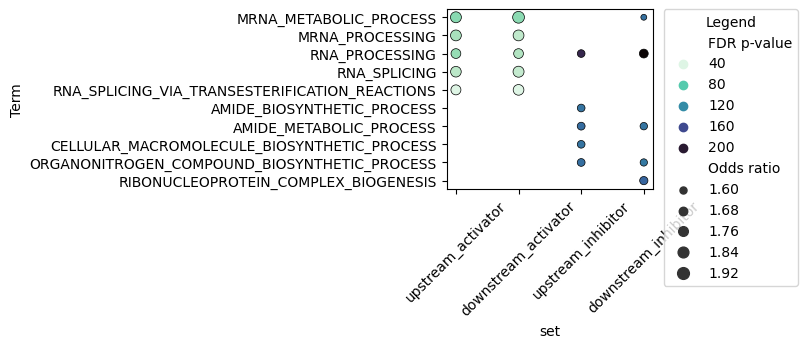

In [19]:
# Make a copy so we don't overwrite original
to_plot = go_pvals.copy()

# --- Define x-axis order explicitly ---
x_order = ["upstream_activator", "downstream_activator", 
           "upstream_inhibitor", "downstream_inhibitor"]

# Force x-axis categorical order
to_plot['set'] = pd.Categorical(to_plot['set'], categories=x_order, ordered=True)

# --- Define y-axis order based on "RNA" ---
to_plot['is_RNA'] = to_plot['Term'].str.contains("RNA", case=False, na=False)

# Order: RNA terms on top, others below, each sorted alphabetically
y_order = (to_plot.sort_values(["is_RNA","Term"], ascending=[False, True])
                 ['Term'].drop_duplicates().tolist())
to_plot['Term'] = pd.Categorical(to_plot['Term'], categories=y_order, ordered=True)

# --- Plot ---
plt.figure(figsize=(4/1.5, 3.5/1.5))
sns.scatterplot(
    data=to_plot,
    x='set',
    y='Term',
    size=np.log10(to_plot['Odds ratio'] + 1),
    hue=-np.log10(to_plot['FDR p-value']),
    palette='mako_r',
    linewidth=0.5,
    edgecolor='black'
)

plt.xticks(rotation=45)
# Move legend outside
plt.legend(
    bbox_to_anchor=(1.05, 1),   # position: 5% to the right of the plot
    loc='upper left',           # anchor location relative to bbox
    borderaxespad=0.,           # space between plot and legend
    title="Legend"              # optional custom title
)

plt.tight_layout()
plt.savefig('/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/notebooks/revision/figures/screen_candidate_decoupler.png')
plt.savefig('/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/notebooks/revision/figures/screen_candidate_decoupler.svg')
plt.savefig('/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/notebooks/revision/figures/screen_candidate_decoupler.jpg')